In [1]:
import plotly as plty
from plotly import express as px
from plotly import graph_objects as go
import plotly.figure_factory as ff
import pandas as pd 
cmap = px.colors.diverging.Spectral
from google.colab import drive
root = "/content/drive"
drive.mount(root)
import os 
os.chdir("/content/drive/My Drive/combustion data")
import pandas as pd 
os.chdir("PCAfold")
os.listdir()
!python setup.py build_ext --inplace
!python setup.py install
from PCAfold import PCA
from PCAfold import preprocess
from PCAfold import reduction
from PCAfold import analysis
from PCAfold import KReg
import numpy as np
import matplotlib.pyplot as plt
import pickle
import multiprocessing as multiproc
!pip install faiss-gpu
!apt-get install libomp-dev
import faiss 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
running build_ext
running install
running build
running build_py
running build_ext
running install_lib
running install_egg_info
Removing /usr/local/lib/python3.7/dist-packages/PCAfold-1.0.0.egg-info
Writing /usr/local/lib/python3.7/dist-packages/PCAfold-1.0.0.egg-info
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (5.0.1-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [2]:
%run -i gpr.py
%run -i dml.py

In [3]:
src_p = "transient-h2-burke-flamelet-source.p"
state_p = "transient-h2-burke-flamelet-state.p" 
X_scaled, S_X_scaled = preprocess_data(src_p, state_p, 3, "pareto", False)

['T', 'H', 'H2', 'O', 'OH', 'H2O', 'O2', 'HO2', 'H2O2']


In [4]:
m1 = np.loadtxt("h2_burke_transient_dml_1.csv", delimiter= ",")
from sklearn import preprocessing
transformed_mat = X_scaled @ np.real(m1)
transformed_mat = transformed_mat.astype(np.float32)
transformed_mat, Idx = np.unique(transformed_mat, return_index = True , axis = 0)
transformed_srcs = S_X_scaled @ np.real(m1) 
transformed_srcs = transformed_srcs[Idx,:]

In [5]:
v_y = singular_kernel_average(transformed_mat,transformed_srcs,3, singular_kernel_minus,transformed_mat,transformed_srcs)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


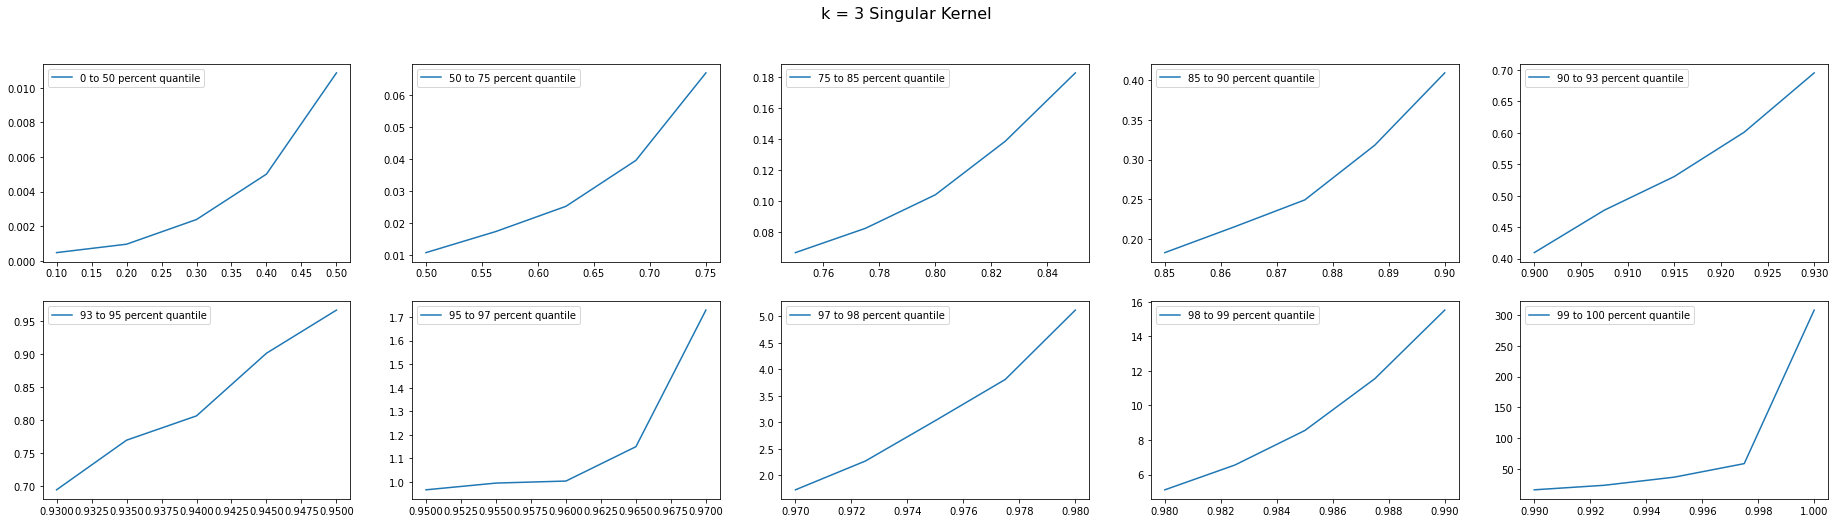

In [6]:
fig, axs = plt.subplots(2,5, figsize = (32,8))
axs[0,0].plot(np.linspace(0.1, 0.5, 5), np.quantile(v_y, np.linspace(0.1, 0.5, 5)), label = "0 to 50 percent quantile")
axs[0,0].legend()
axs[0,1].plot(np.linspace(0.5, 0.75, 5), np.quantile(v_y, np.linspace(0.5, 0.75, 5)), label = "50 to 75 percent quantile")
axs[0,1].legend()
axs[0,2].plot(np.linspace(0.75, 0.85, 5), np.quantile(v_y, np.linspace(0.75, 0.85, 5)), label = "75 to 85 percent quantile")
axs[0,2].legend()
axs[0,3].plot(np.linspace(0.85, 0.90, 5), np.quantile(v_y, np.linspace(0.85, 0.90, 5)), label = "85 to 90 percent quantile")
axs[0,3].legend()
axs[0,4].plot(np.linspace(0.9, 0.93, 5), np.quantile(v_y, np.linspace(0.9, 0.93, 5)), label = "90 to 93 percent quantile")
axs[0,4].legend()
fig.suptitle('k = 3 Singular Kernel', fontsize=16)
axs[1,0].plot(np.linspace(0.93, 0.95, 5), np.quantile(v_y, np.linspace(0.93, 0.95, 5)), label = "93 to 95 percent quantile")
axs[1,0].legend()
axs[1,1].plot(np.linspace(0.95, 0.97, 5), np.quantile(v_y, np.linspace(0.95, 0.97, 5)), label = "95 to 97 percent quantile")
axs[1,1].legend()
axs[1,2].plot(np.linspace(0.97, 0.98, 5), np.quantile(v_y, np.linspace(0.97, 0.98, 5)), label = "97 to 98 percent quantile")
axs[1,2].legend()
axs[1,3].plot(np.linspace(0.98, 0.99, 5), np.quantile(v_y, np.linspace(0.98, 0.99, 5)), label = "98 to 99 percent quantile")
axs[1,3].legend()
axs[1,4].plot(np.linspace(0.99, 1, 5), np.quantile(v_y, np.linspace(0.99, 1, 5)), label = "99 to 100 percent quantile")
axs[1,4].legend()


In [7]:
n,d = transformed_mat.shape
index = np.random.choice(n, size = int(n * 0.9), replace= False)
X_1 = transformed_mat[index,:]
Y_1 = transformed_srcs[index, :]
X_2 = np.delete(transformed_mat, index, axis = 0)
Y_2 = np.delete(transformed_srcs, index, axis = 0)

In [8]:
v_y_2 = singular_kernel_average(X_1,Y_1,3, singular_kernel_minus,X_2,Y_2)

In [9]:
np.quantile(v_y_2, np.linspace(0.1,1,10))

array([2.15377732e-03, 4.22901048e-03, 7.80422074e-03, 1.52102024e-02,
       2.99038543e-02, 5.05991625e-02, 1.00935317e-01, 1.95527203e-01,
       4.85255658e-01, 2.36227329e+02])

In [10]:
v_y_1 = knn_gpr_average(transformed_mat,transformed_srcs,4,transformed_mat,transformed_srcs)

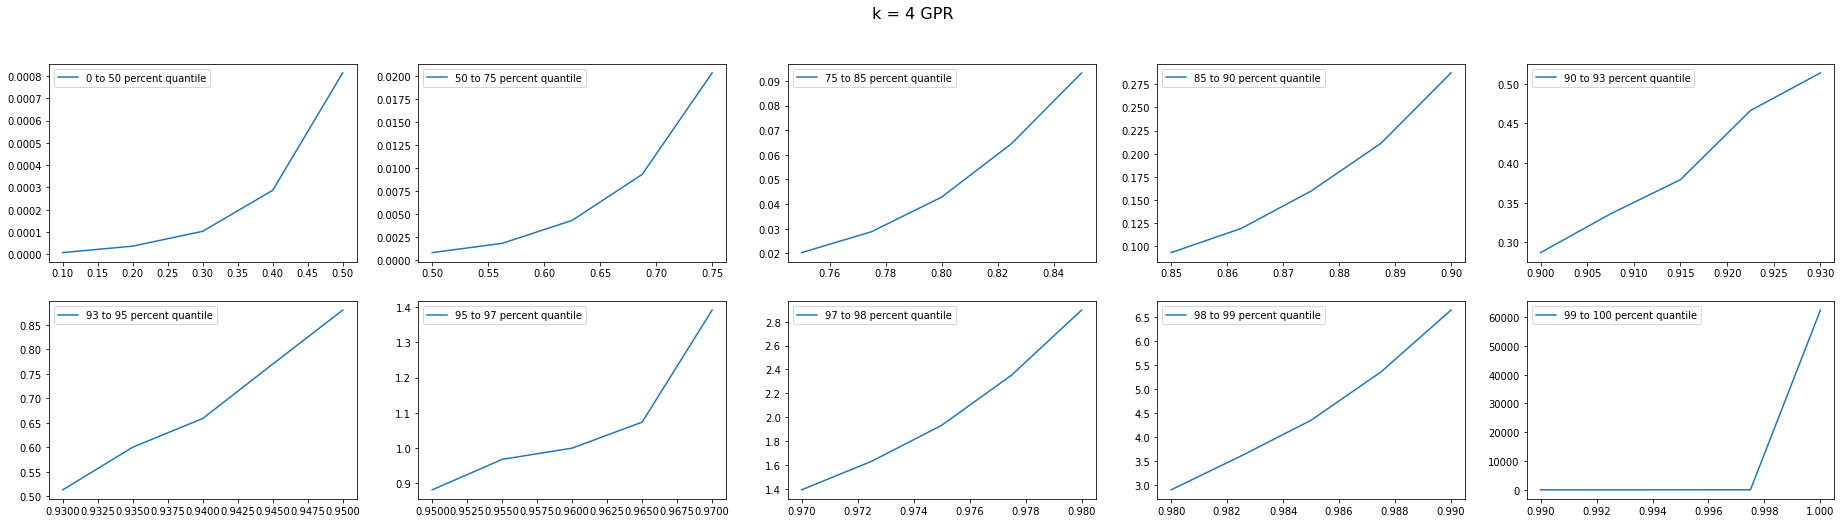

In [11]:
fig, axs = plt.subplots(2,5, figsize = (32,8))
axs[0,0].plot(np.linspace(0.1, 0.5, 5), np.quantile(v_y_1, np.linspace(0.1, 0.5, 5)), label = "0 to 50 percent quantile")
axs[0,0].legend()
axs[0,1].plot(np.linspace(0.5, 0.75, 5), np.quantile(v_y_1, np.linspace(0.5, 0.75, 5)), label = "50 to 75 percent quantile")
axs[0,1].legend()
axs[0,2].plot(np.linspace(0.75, 0.85, 5), np.quantile(v_y_1, np.linspace(0.75, 0.85, 5)), label = "75 to 85 percent quantile")
axs[0,2].legend()
axs[0,3].plot(np.linspace(0.85, 0.90, 5), np.quantile(v_y_1, np.linspace(0.85, 0.90, 5)), label = "85 to 90 percent quantile")
axs[0,3].legend()
axs[0,4].plot(np.linspace(0.9, 0.93, 5), np.quantile(v_y_1, np.linspace(0.9, 0.93, 5)), label = "90 to 93 percent quantile")
axs[0,4].legend()
fig.suptitle('k = 4 GPR', fontsize=16)
axs[1,0].plot(np.linspace(0.93, 0.95, 5), np.quantile(v_y_1, np.linspace(0.93, 0.95, 5)), label = "93 to 95 percent quantile")
axs[1,0].legend()
axs[1,1].plot(np.linspace(0.95, 0.97, 5), np.quantile(v_y_1, np.linspace(0.95, 0.97, 5)), label = "95 to 97 percent quantile")
axs[1,1].legend()
axs[1,2].plot(np.linspace(0.97, 0.98, 5), np.quantile(v_y_1, np.linspace(0.97, 0.98, 5)), label = "97 to 98 percent quantile")
axs[1,2].legend()
axs[1,3].plot(np.linspace(0.98, 0.99, 5), np.quantile(v_y_1, np.linspace(0.98, 0.99, 5)), label = "98 to 99 percent quantile")
axs[1,3].legend()
axs[1,4].plot(np.linspace(0.99, 1, 5), np.quantile(v_y_1, np.linspace(0.99, 1, 5)), label = "99 to 100 percent quantile")
axs[1,4].legend()


In [12]:
v_y_3 = knn_gpr_average(X_1,Y_1,4,X_2,Y_2)

In [13]:
np.quantile(v_y_3, np.linspace(0.1,1,10))

array([1.67542738e-05, 5.02636300e-05, 1.38912814e-04, 3.59301526e-04,
       1.19145686e-03, 4.30999278e-03, 1.33356467e-02, 4.71956172e-02,
       2.51127705e-01, 8.72144124e+01])